In [1]:
import os 
import json
import tweepy
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Twitter API credentials from external file

Create a json file named `twitter_credentials.json`

```
{
    "api_key": "...",
    "api_secret": "...",
    "access_token": "...",
    "access_secret": "...",
    "bearer_token": "..."
}
```

In [2]:
credentials_file = 'twitter_credentials.json'

with open(credentials_file) as credentials_data:
   api_data = json.load(credentials_data)

api_key = api_data['api_key']
api_secret = api_data['api_secret']
access_token = api_data['access_token']
access_secret = api_data['access_secret']
bearer_token = api_data['bearer_token']

In [3]:

client = tweepy.Client(
    consumer_key=api_key, 
    consumer_secret=api_secret, 
    access_token=access_token, 
    access_token_secret=access_secret, 
    bearer_token=bearer_token,
    wait_on_rate_limit=True,
    return_type=dict
)

In [4]:
accounts = ["mizzaro", "Miccighel_"]
data_folder = "data"
excluded_users_file = "excluded_usernames.json"
existing_accounts = ["mizzaro", "Miccighel_"]

def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

def read_json(path, verbose=True):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        if verbose:
            print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

# check if username is excluded
def is_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username in excluded_users_list:
        return True
    else:
        return False

# add username to excluded lists
def add_to_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username not in excluded_users_list:
        excluded_users_data['excluded'].append(username)
        serialize_json(data_folder, excluded_users_file, excluded_users_data)
    else:
        print(f"User {username} is already present in excluded list")

# check if username is already present
def is_present(username):
    if username in existing_accounts:
        return True
    else:
        return False

# add username to existing lists
def add_to_existing(username):
    if username not in existing_accounts:
        existing_accounts.append(username)
    else:
        print(f"User {username} is already present in existing list")

# add to existing list from json file
def add_to_existing_from_file(filename):
    accounts_list = read_json(filename)
    for account in accounts_list:
       add_to_existing(account['username'])

# get tweets
def get_tweetsv2(username, quantity, userid=None):
    tweets = []
    tweets_file = f"{data_folder}/{username}_tweets.json"

    data_total = quantity

    if not os.path.exists(tweets_file):
        # Get Tweets from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get 5 most recent tweets
        response = client.get_users_tweets(
                    id=user['id'], tweet_fields=['created_at', 'lang', 'public_metrics'],
                    max_results=data_total
                    )
    else:
        # Get Tweets from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(tweets_file)
    
    for data in response['data']:
        tweets.append(data)
    return tweets

# get followers
def get_followersv2(username, quantity, userid=None, save_all=True):
    followers_of_user = []
    all_followers_of_user = []
    all_followers_file = f"{data_folder}/{username}_followers.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_followers_file):
        # Get Followers from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 followers
        response = client.get_users_followers(
                    id=user['id'], user_fields=['name', 'description', 'location', 'protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Followers from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_followers_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_followers_of_user.append(data)
        # Skip excluded username or already present accounts:
        if is_excluded(data['username']) or is_present(data['username']):
            continue
        if(len(followers_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            followers_of_user.append(data)
            add_to_existing(data['username'])
    if save_all:                
        serialize_json(data_folder, f"{username}_followers.json", all_followers_of_user)
    print(f"Found {len(followers_of_user)} followers for user {username}")
    if len(followers_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return followers_of_user

# get following
def get_followingv2(username, quantity, userid=None, save_all=False):
    following_of_user = []
    all_following_of_user = []
    all_following_file = f"{data_folder}/{username}_following.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_following_file):
        # Get Following from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 following
        response = client.get_users_following(
                    id=user['id'], user_fields=['protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Following from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_following_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_following_of_user.append(data)
        # Skip excluded username or already present accounts:
        if is_excluded(data['username']) or is_present(data['username']):
            continue
        if(len(following_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            following_of_user.append(data)
            add_to_existing(data['username'])
    if save_all:                
        serialize_json(data_folder, f"{username}_following.json", all_following_of_user)
    print(f"Found {len(following_of_user)} following of user {username}")
    if len(following_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return following_of_user

# draw matplotlib subplot - 4 rows, 2 columns
def draw(index, G, pos, measures, measure_name):
    plt.subplot(4,2,index)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    edges = nx.draw_networkx_edges(G, pos, node_size=200, arrowsize=5, arrowstyle='->')
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')


# Root level accounts details

In [5]:
if not os.path.exists(f"{data_folder}/root_level_accounts.json"):
    # get root accounts details 
    response = client.get_users(usernames=accounts, user_fields=['name', 'description', 'location', 'protected', 'public_metrics'])
    serialize_json(data_folder, "root_level_accounts.json", response['data'])

# First level followers

In [6]:

if not os.path.exists(f"{data_folder}/first_level_followers.json"):
    first_level_followers = []
    for account in accounts:
        # Get 5 followers and save all followers list
        first_level_followers.extend(get_followersv2(account, 5))
    
    serialize_json(data_folder, "first_level_followers.json", first_level_followers)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/first_level_followers.json")

Data read from path: data/first_level_followers.json


# First level following

In [7]:
if not os.path.exists(f"{data_folder}/first_level_following.json"):
    first_level_following = []
    for account in accounts:
        # Get 5 following and save all following list
        first_level_following.extend(get_followingv2(account, 5))

    serialize_json(data_folder, "first_level_following.json", first_level_following)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/first_level_following.json")

Data read from path: data/first_level_following.json


# Second level followers

In [8]:
if not os.path.exists(f"{data_folder}/second_level_followers.json"):
    second_level_followers = []

    # Get followers from first-level-followers
    first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

    for follower in first_level_followers_list:
        # Get 5 followers and save all followers list - we need all information about follower leafs
        second_level_followers.extend(get_followersv2(follower['username'], 5, follower['id']))
        
    # Get followers from first-level-following
    first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

    for following in first_level_following_list:
        # Get 5 followers and do not save all followers list - we do not need information about following leafs
        second_level_followers.extend(get_followersv2(following['username'], 5, following['id'], False))

    serialize_json(data_folder, "second_level_followers.json", second_level_followers)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/second_level_followers.json")

Data read from path: data/second_level_followers.json


# Second level following

In [9]:
if not os.path.exists(f"{data_folder}/second_level_following.json"):
    second_level_following = []

    # Get following from first-level-followers
    first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

    for follower in first_level_followers_list:
        # Get 5 following and save all followings list - we need all information about follower leafs
        second_level_following.extend(get_followingv2(follower['username'], 5, follower['id'], True))

    # Get following from first-level-following
    first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

    for following in first_level_following_list:
        # Get 5 following and do not save all followers list - we do not need information about following leafs
        second_level_following.extend(get_followingv2(following['username'], 5, following['id']))

    serialize_json(data_folder, "second_level_following.json", second_level_following)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/second_level_following.json")

Data read from path: data/second_level_following.json


# Last 5 tweets of root accounts, first and second level followers

In [10]:
# Get tweets from root accounts
root_level_accounts_list = read_json(f"{data_folder}/root_level_accounts.json")

for account in root_level_accounts_list:
    if not os.path.exists(f"{data_folder}/{account['username']}_tweets.json"):
        tweets = get_tweetsv2(account['username'], 5, account['id'])
        serialize_json(data_folder, f"{account['username']}_tweets.json", tweets)

# Get tweets from first-level-followers
first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

for follower in first_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

# Get tweets from second-level-followers
second_level_followers_list = read_json(f"{data_folder}/second_level_followers.json")

for follower in second_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

Data read from path: data/root_level_accounts.json
Data read from path: data/first_level_followers.json
Data read from path: data/second_level_followers.json


# Third level followers and following

In [11]:
# Get all followers from second-level-followers
third_level_followers = []
for follower in second_level_followers_list:
    # Save all followers list - we need all information about follower leafs
    third_level_followers.extend(get_followersv2(follower['username'], 0, follower['id']))

# Get all following from second-level-followers
third_level_following = []
for follower in second_level_followers_list:
    # Save all following list - we need all information about follower leafs
    third_level_following.extend(get_followingv2(follower['username'], 0, follower['id'], True))

Processing user with username Marwah_k from file
Data read from path: data/Marwah_k_followers.json
Found 0 followers for user Marwah_k
Processing user with username ivrik from file
Data read from path: data/ivrik_followers.json
Found 0 followers for user ivrik
Processing user with username ameertawfik from file
Data read from path: data/ameertawfik_followers.json
Found 0 followers for user ameertawfik
Processing user with username aleksbobic from file
Data read from path: data/aleksbobic_followers.json
Found 0 followers for user aleksbobic
Processing user with username debforit from file
Data read from path: data/debforit_followers.json
Found 0 followers for user debforit
Processing user with username gael_dias from file
Data read from path: data/gael_dias_followers.json
Found 0 followers for user gael_dias
Processing user with username Nthakur20 from file
Data read from path: data/Nthakur20_followers.json
Found 0 followers for user Nthakur20
Processing user with username AthmaniAmine 

# Create nodes with all attributes (id, profile details, 5 tweets, public metrics)

In [12]:
import itertools 
nodes = []

for follower in itertools.chain(root_level_accounts_list, first_level_followers_list, second_level_followers_list):
    node_attributes = {}
    node_attributes['username'] = follower['username']
    node_attributes['name'] = follower['name']
    node_attributes['location'] = follower['location'] if 'location' in follower else None
    node_attributes['metrics'] = follower['public_metrics']
    node_attributes['tweets'] = read_json(f"{data_folder}/{follower['username']}_tweets.json", False)
    nodes.append((follower['id'], node_attributes))

# Create Social Network graph

In [13]:
from pyvis.network import Network

# Add project members name as attribute of the graph
graph = nx.MultiDiGraph(members=['Agrate Giulio','Bibalo Simone','De Nardi Gianluca Giuseppe Maria','Giunta Marco'])

graph.add_nodes_from(nodes)

# Add egdes with following or follower attribute
for node in graph.nodes:
    user_followers = read_json(f"{data_folder}/{graph.nodes[node]['username']}_followers.json", False)
    for follower in user_followers:
        if graph.has_node(follower['id']):
            graph.add_edge(node, follower['id'], key='follower', title=f"follower - {graph.nodes[node]['username']} -> {follower['username']}")
    user_following = read_json(f"{data_folder}/{graph.nodes[node]['username']}_following.json", False)
    for following in user_following:
        if graph.has_node(following['id']):
            graph.add_edge(node, following['id'], key='following', title=f"following - {graph.nodes[node]['username']} <- {following['username']}", color='#DB6400')

nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Social Network Graph",
    directed=True,
)

nt.set_edge_smooth('dynamic')
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(neighbor_map[node['id']])

# Save graph in Python pickle format.
nx.write_gpickle(graph, "graphs/social_network_graph.pkl")

# Create Followers network sub-graph

In [14]:
# Get edges with follower attribute and create followers graph
follower_edges = [(u, v, k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'follower']
followers_graph = graph.edge_subgraph(follower_edges).copy()

follower_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Followers Network Graph",
    directed=True
)

follower_nt.set_edge_smooth('dynamic')
follower_nt.from_nx(followers_graph)
follower_neighbor_map = follower_nt.get_adj_list()
for node in follower_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(follower_neighbor_map[node['id']])

# Save graph in Python pickle format.
nx.write_gpickle(followers_graph, "graphs/followers_network_graph.pkl")

 # Create Following network sub-graphs

In [15]:
# Get edges with following attribute and create following graph
following_edges = [(u,v,k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'following']
following_graph = graph.edge_subgraph(following_edges).copy()

following_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Following Network Graph",
    directed=True
)

following_nt.set_edge_smooth('dynamic')
following_nt.from_nx(following_graph)
following_neighbor_map = following_nt.get_adj_list()
for node in following_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(following_neighbor_map[node['id']])

# Save graph in Python pickle format.
nx.write_gpickle(following_graph, "graphs/following_network_graph.pkl")

# Create interactive visualizations of graphs

In [16]:
# Social Network Graph
nt.show("html/social_network_graphs.html")

# Followers Network Graph
follower_nt.show("html/follower_network_graphs.html")

# Following Network Graph
following_nt.show("html/following_network_graphs.html")

# Degree distribution of Social Network graph

Nodes:  112
Edges:  391
Average degree:  3.4910714285714284
SCC:  35
WCC:  35


Text(0.5, 1.0, 'Social Network Degree Distribution')

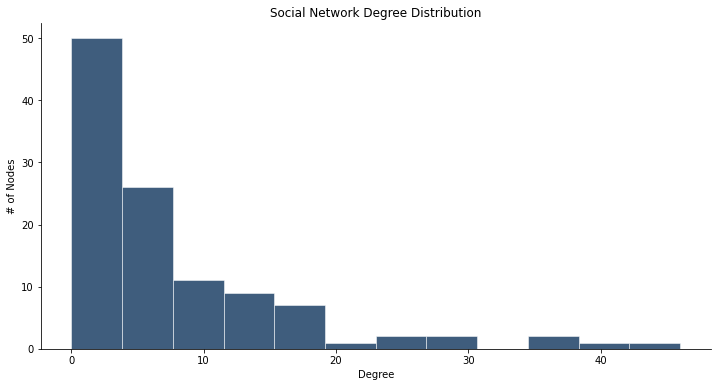

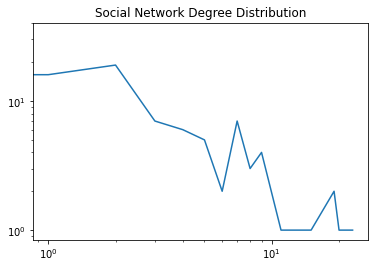

In [17]:
# Generic graphs data
N, K = graph.order(), graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(graph))
print("WCC: ", nx.number_weakly_connected_components(graph))


degs = [i[1] for i in graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto', linewidth=0.5, edgecolor="white")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.title("Social Network Degree Distribution")

degs = {}
for n, d in graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Social Network Degree Distribution")

# Degree distribution of Followers Network graph

Nodes:  78
Edges:  195
Average degree:  2.5
SCC:  26
WCC:  1


Text(0.5, 1.0, 'Followers Network Degree Distribution')

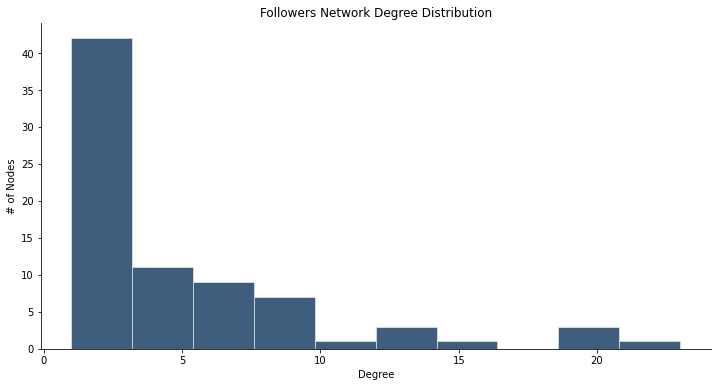

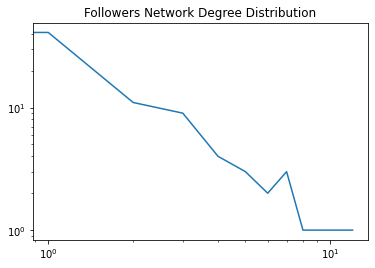

In [18]:
# Generic graphs data
N, K = followers_graph.order(), followers_graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(followers_graph))
print("WCC: ", nx.number_weakly_connected_components(followers_graph))


degs = [i[1] for i in followers_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto', linewidth=0.5, edgecolor="white")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.title("Followers Network Degree Distribution")

degs = {}
for n, d in followers_graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Followers Network Degree Distribution")

# Degree distribution of Following Network graph

Nodes:  78
Edges:  196
Average degree:  2.5128205128205128
SCC:  26
WCC:  1


Text(0.5, 1.0, 'Following Network Degree Distribution')

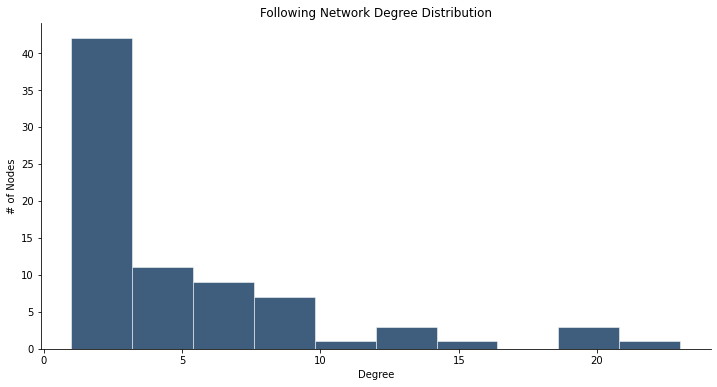

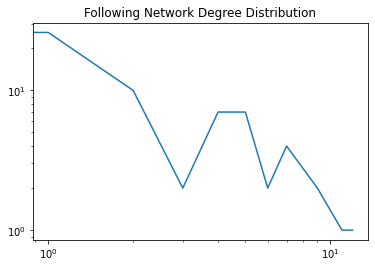

In [19]:
# Generic graphs data
N, K = following_graph.order(), following_graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(following_graph))
print("WCC: ", nx.number_weakly_connected_components(following_graph))


degs = [i[1] for i in following_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto', linewidth=0.5, edgecolor="white")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.title("Following Network Degree Distribution")

degs = {}
for n, d in following_graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Following Network Degree Distribution")

# Clustering coefficient of Social Network graph

In [20]:
# Compute the clustering coefficient for nodes.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
digraph = nx.DiGraph(graph)

# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(digraph)

# Average clustering coefficient
avg_clust_coef = nx.average_clustering(digraph)
print("Average clustering: ", avg_clust_coef)

# Average clustering coefficient of maximum strongly connected components of graph
print("Average clustering max scc:", nx.average_clustering(nx.DiGraph(graph).subgraph(max(nx.strongly_connected_components(nx.DiGraph(graph)), key=len))))


Average clustering:  0.19367382369614508
Average clustering max scc: 0.2780957468457468


# Clustering coefficient of Followers Network graph

In [21]:
# Compute the clustering coefficient for nodes.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
followers_digraph = nx.DiGraph(followers_graph)
# Clustering coefficient of all nodes (in a dictionary)
followers_clust_coefficients = nx.clustering(followers_digraph)

# Average clustering coefficient
followers_avg_clust_coef = nx.average_clustering(followers_digraph)
print("Average clustering: ", followers_avg_clust_coef)

Average clustering:  0.24954435625747676


# Clustering coefficient of Following Network graph

In [22]:
# Compute the clustering coefficient for nodes.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
following_digraph = nx.DiGraph(following_graph)

# Clustering coefficient of all nodes (in a dictionary)
following_clust_coefficients = nx.clustering(following_digraph)

# Average clustering coefficient
following_avg_clust_coef = nx.average_clustering(following_digraph)
print("Average clustering: ", following_avg_clust_coef)

Average clustering:  0.24432646029884003


# Verify if graphs are connected​ or bipartite​

In [23]:
# We can verify if a graph is connected only for undirected graphs.
print("Social Network graph is connected: ", nx.is_connected(graph.to_undirected()))

from networkx.algorithms import bipartite
print("Social Network graph is bipartite: ", bipartite.is_bipartite(graph))

# We can verify if a graph is connected only for undirected graphs.
print("Followers Network graph is connected: ", nx.is_connected(followers_graph.to_undirected()))

from networkx.algorithms import bipartite
print("Followers Network graph is bipartite: ", bipartite.is_bipartite(followers_graph))

# We can verify if a graph is connected only for undirected graphs.
print("Following Network graph is connected: ", nx.is_connected(following_graph.to_undirected()))

from networkx.algorithms import bipartite
print("Following Network graph is bipartite: ", bipartite.is_bipartite(following_graph))

Social Network graph is connected:  False
Social Network graph is bipartite:  False
Followers Network graph is connected:  True
Followers Network graph is bipartite:  False
Following Network graph is connected:  True
Following Network graph is bipartite:  False


# Center, Radius, Average and Maximum distance of Social Network Graph

In [24]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
graph_components = nx.strongly_connected_components(nx.DiGraph(graph))
# We want the largest connected component, it’s more efficient to use max instead of sort.
graph_mc = max(graph_components, key=len)
graph_mc_sub = graph.subgraph(graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
graph_center_nodes = nx.center(graph_mc_sub)
graph_center_node1_username = graph_mc_sub.nodes[graph_center_nodes[0]]['username']
graph_center_node2_username = graph_mc_sub.nodes[graph_center_nodes[1]]['username']
print("Social Network Center nodes: {} - {}".format(graph_center_node1_username, graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Social Network Radius: ", nx.radius(graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Social Network Average distance: ", nx.average_shortest_path_length(graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Social Network Maximum distance: ", nx.diameter(graph_mc_sub))

Social Network Center nodes: mizzaro - acai2021
Social Network Radius:  4
Social Network Average distance:  3.8506493506493507
Social Network Maximum distance:  7


# Center, Radius, Average and Maximum distance of Followers Network Graph

In [25]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
followers_graph_components = nx.strongly_connected_components(nx.DiGraph(followers_graph))
# We want the largest connected component, it’s more efficient to use max instead of sort.
followers_graph_mc = max(followers_graph_components, key=len)
followers_graph_mc_sub = followers_graph.subgraph(followers_graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
followers_graph_center_nodes = nx.center(followers_graph_mc_sub)
followers_graph_center_node1_username = followers_graph_mc_sub.nodes[followers_graph_center_nodes[0]]['username']
followers_graph_center_node2_username = followers_graph_mc_sub.nodes[followers_graph_center_nodes[1]]['username']
print("Followers Network Center nodes: {} - {}".format(followers_graph_center_node1_username, followers_graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Followers Network Radius: ", nx.radius(followers_graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Followers Network Average distance: ", nx.average_shortest_path_length(followers_graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Followers Network Maximum distance: ", nx.diameter(followers_graph_mc_sub))

Followers Network Center nodes: danulaera - rodger_benham
Followers Network Radius:  3
Followers Network Average distance:  2.4729064039408866
Followers Network Maximum distance:  5


# Center, Radius, Average and Maximum distance of Following Network Graph

In [26]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
following_graph_components = nx.strongly_connected_components(nx.DiGraph(following_graph))
# We want the largest connected component, it’s more efficient to use max instead of sort.
following_graph_mc = max(following_graph_components, key=len)
following_graph_mc_sub = following_graph.subgraph(following_graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
following_graph_center_nodes = nx.center(following_graph_mc_sub)
following_graph_center_node1_username = following_graph_mc_sub.nodes[following_graph_center_nodes[0]]['username']
following_graph_center_node2_username = following_graph_mc_sub.nodes[following_graph_center_nodes[1]]['username']
print("Following Network Center nodes: {} - {}".format(following_graph_center_node1_username, following_graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Following Network Radius: ", nx.radius(following_graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Following Network Average distance: ", nx.average_shortest_path_length(following_graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Following Network Maximum distance: ", nx.diameter(following_graph_mc_sub))

Following Network Center nodes: mizzaro - rodger_benham
Following Network Radius:  3
Following Network Average distance:  2.4729064039408866
Following Network Maximum distance:  5


# Compute centrality measures (Betweenness, Closeness, Degree, In-degree, Out-degree, Page Rank, HITS) on Social Network Graph

In [27]:
# Betweenness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_bet_cen = nx.betweenness_centrality(nx.DiGraph(graph))

# Closeness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_clo_cen = nx.closeness_centrality(nx.DiGraph(graph))

# Compute the degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_deg_cen = nx.degree_centrality(nx.DiGraph(graph))

# Compute the in-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_in_deg_cen = nx.in_degree_centrality(nx.DiGraph(graph))

# Compute the out-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_out_deg_cen = nx.out_degree_centrality(nx.DiGraph(graph))

# PageRank of the nodes in the graph.
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_page_rank = nx.pagerank(nx.DiGraph(graph))

# HITS hubs and authorities values for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
graph_hits = nx.hits(nx.DiGraph(graph))


# Plot Centrality measures of Social Network Graph

Text(0.5, 0.98, 'Social Network Graph centrality measures')

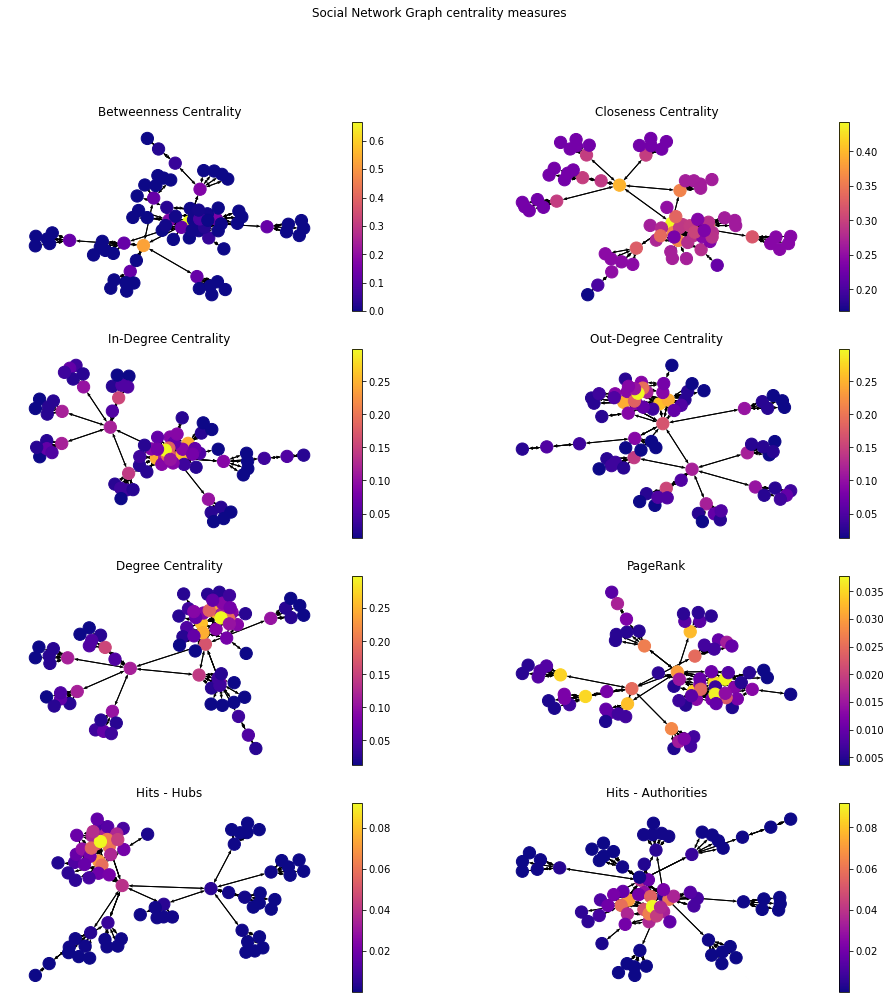

In [28]:
# To avoid problem, we need to use the largest strongly connected component of graph

plt.figure(figsize=(16,16))

draw(
    1,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.betweenness_centrality(nx.DiGraph(graph_mc_sub)),
    'Betweenness Centrality'
)

draw(
    2,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.closeness_centrality(graph_mc_sub),
    'Closeness Centrality'
)

draw(
    3,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.in_degree_centrality(graph_mc_sub),
    'In-Degree Centrality'
)

draw(
    4,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.out_degree_centrality(graph_mc_sub),
    'Out-Degree Centrality'
)

draw(
    5,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.in_degree_centrality(graph_mc_sub),
    'Degree Centrality'
)

draw(
    6,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub),
    nx.pagerank(graph_mc_sub, alpha=0.85),
    'PageRank'
)

graph_mc_sub_hits = nx.hits(graph_mc_sub)
draw(
    7,
    graph_mc_sub, 
    nx.spring_layout(graph_mc_sub), 
    graph_mc_sub_hits[0],
    'Hits - Hubs'
)

draw(
    8,
    graph_mc_sub,
    nx.spring_layout(graph_mc_sub),
    graph_mc_sub_hits[1],
    'Hits - Authorities'
)

plt.suptitle("Social Network Graph centrality measures")


# Compute centrality measures (Betweenness, Closeness, Degree, In-degree, Out-degree, Page Rank, HITS) on Followers Network Graph

In [29]:
# Betweenness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_bet_cen = nx.betweenness_centrality(nx.DiGraph(followers_graph))

# Closeness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_clo_cen = nx.closeness_centrality(nx.DiGraph(followers_graph))

# Compute the degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_deg_cen = nx.degree_centrality(nx.DiGraph(followers_graph))

# Compute the in-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_in_deg_cen = nx.in_degree_centrality(nx.DiGraph(followers_graph))

# Compute the out-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_out_deg_cen = nx.out_degree_centrality(nx.DiGraph(followers_graph))

# PageRank of the nodes in the graph.
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_page_rank = nx.pagerank(nx.DiGraph(followers_graph))

# HITS hubs and authorities values for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_hits = nx.hits(nx.DiGraph(followers_graph))

# Plot Centrality measures of Followers Network Graph

Text(0.5, 0.98, 'Followers Network Graph centrality measures')

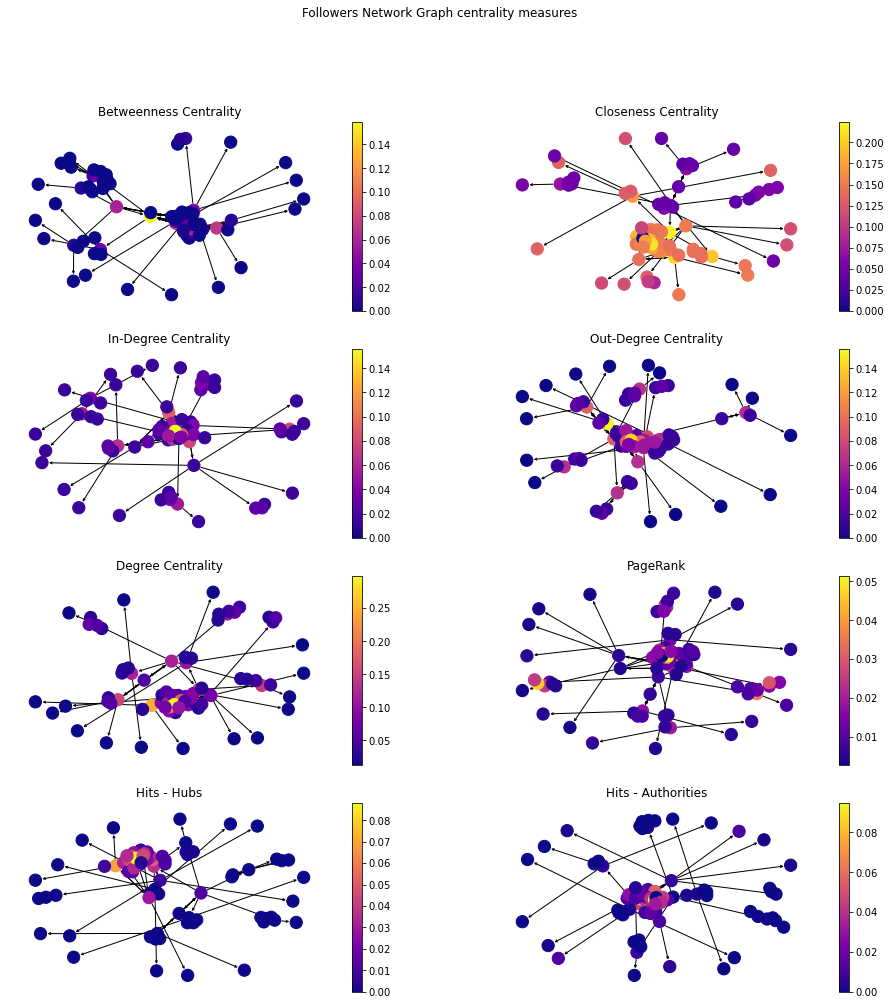

In [30]:
plt.figure(figsize=(16,16))

draw(
    1,
    followers_graph, 
    nx.spring_layout(followers_graph),
    followers_graph_bet_cen,
    'Betweenness Centrality'
)

draw(
    2,
    followers_graph, 
    nx.spring_layout(followers_graph),
    followers_graph_clo_cen,
    'Closeness Centrality'
)

draw(
    3,
    followers_graph, 
    nx.spring_layout(followers_graph),
    followers_graph_in_deg_cen,
    'In-Degree Centrality'
)

draw(
    4,
    followers_graph, 
    nx.spring_layout(followers_graph),
    followers_graph_out_deg_cen,
    'Out-Degree Centrality'
)

draw(
    5,
    followers_graph, 
    nx.spring_layout(followers_graph),
    followers_graph_deg_cen,
    'Degree Centrality'
)

draw(
    6,
    followers_graph,
    nx.spring_layout(followers_graph),
    followers_graph_page_rank,
    'PageRank'
)

draw(
    7,
    followers_graph, 
    nx.spring_layout(followers_graph), 
    followers_graph_hits[0],
    'Hits - Hubs'
)

draw(
    8,
    followers_graph,
    nx.spring_layout(followers_graph),
    followers_graph_hits[1],
    'Hits - Authorities'
)

plt.suptitle("Followers Network Graph centrality measures")


# Compute centrality measures (Betweenness, Closeness, Degree, In-degree, Out-degree, Page Rank, HITS) on Following Network Graph

In [31]:
# Betweenness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_bet_cen = nx.betweenness_centrality(nx.DiGraph(following_graph))

# Closeness centrality
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_clo_cen = nx.closeness_centrality(nx.DiGraph(following_graph))

# Compute the degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_deg_cen = nx.degree_centrality(nx.DiGraph(following_graph))

# Compute the in-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_in_deg_cen = nx.in_degree_centrality(nx.DiGraph(following_graph))

# Compute the out-degree centrality for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_out_deg_cen = nx.out_degree_centrality(nx.DiGraph(following_graph))

# PageRank of the nodes in the graph.
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_page_rank = nx.pagerank(nx.DiGraph(following_graph))

# HITS hubs and authorities values for nodes.
# It works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_hits = nx.hits(nx.DiGraph(following_graph))

# Plot Centrality measures of Following Network Graph

Text(0.5, 0.98, 'Following Network Graph centrality measures')

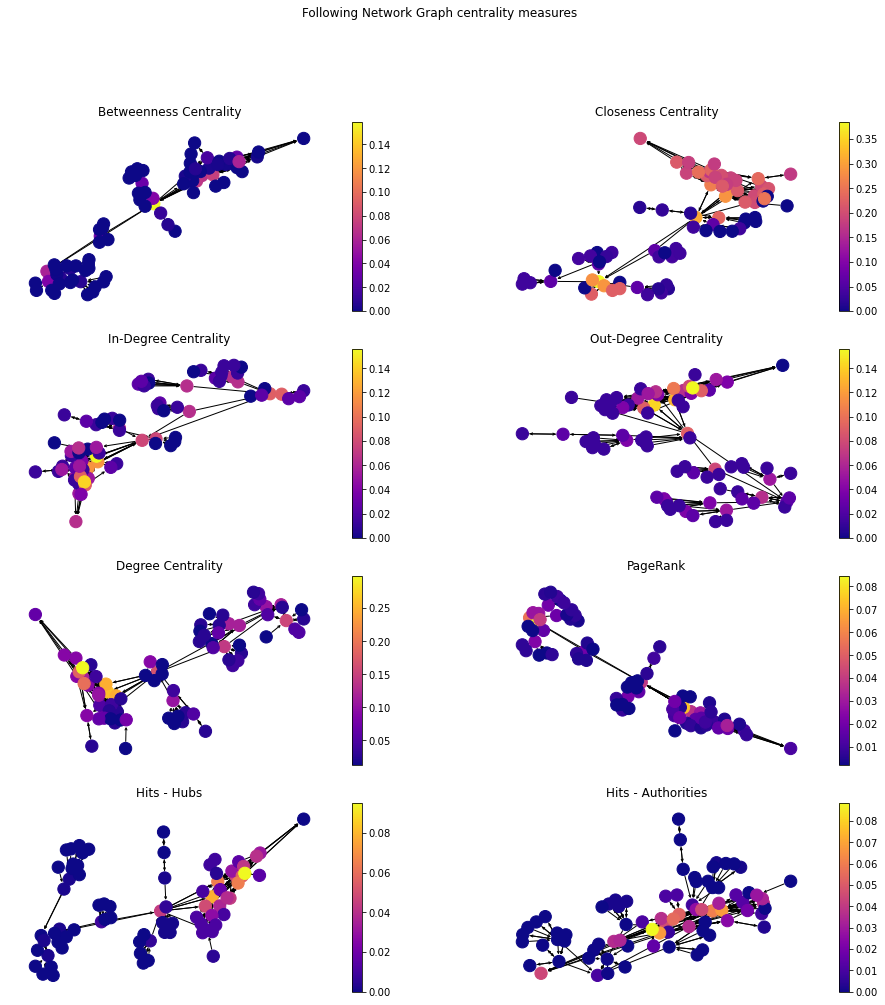

In [32]:
plt.figure(figsize=(16,16))

draw(
    1,
    following_graph, 
    nx.spring_layout(following_graph),
    following_graph_bet_cen,
    'Betweenness Centrality'
)

draw(
    2,
    following_graph, 
    nx.spring_layout(following_graph),
    following_graph_clo_cen,
    'Closeness Centrality'
)

draw(
    3,
    following_graph, 
    nx.spring_layout(following_graph),
    following_graph_in_deg_cen,
    'In-Degree Centrality'
)

draw(
    4,
    following_graph, 
    nx.spring_layout(following_graph),
    following_graph_out_deg_cen,
    'Out-Degree Centrality'
)

draw(
    5,
    following_graph, 
    nx.spring_layout(following_graph),
    following_graph_deg_cen,
    'Degree Centrality'
)

draw(
    6,
    following_graph,
    nx.spring_layout(following_graph),
    following_graph_page_rank,
    'PageRank'
)

draw(
    7,
    following_graph, 
    nx.spring_layout(following_graph), 
    following_graph_hits[0],
    'Hits - Hubs'
)

draw(
    8,
    following_graph,
    nx.spring_layout(following_graph),
    following_graph_hits[1],
    'Hits - Authorities'
)

plt.suptitle("Following Network Graph centrality measures")


# Compute "small-world-ness" of Social Network Graph (Omega and Sigma coefficients)

In [33]:
# Omega
# The small-world coefficient (omega) ranges between -1 and 1.
# Values close to 0 means the G features small-world characteristics.
# Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.
# Graph must be connected, so we MUST use the largest connected component 
omega = nx.algorithms.smallworld.omega(nx.DiGraph(graph_mc_sub).to_undirected())
print("Social Network Omega: ", omega)

# Sigma
# A graph is commonly classified as small-world if sigma > 1.
# Graph must be connected, so we MUST use the largest connected component
sigma = nx.algorithms.smallworld.sigma(nx.DiGraph(graph_mc_sub).to_undirected())
print("Social Network Sigma: ", sigma)

Social Network Omega:  0.2892212692833316
Social Network Sigma:  2.5841348826733244


# Compute "small-world-ness" of Followers Followers Graph (Omega and Sigma coefficients)

In [34]:
# Omega
# The small-world coefficient (omega) ranges between -1 and 1.
# Values close to 0 means the G features small-world characteristics.
# Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.
# Graph must be connected, so we MUST use the largest connected component 
followers_omega = nx.algorithms.smallworld.omega(nx.DiGraph(followers_graph_mc_sub).to_undirected())
print("Followers Network Omega: ", followers_omega)

# Sigma
# A graph is commonly classified as small-world if sigma > 1.
# Graph must be connected, so we MUST use the largest connected component
followers_sigma = nx.algorithms.smallworld.sigma(nx.DiGraph(followers_graph_mc_sub).to_undirected())
print("Followers Network Sigma: ", followers_sigma)

Followers Network Omega:  0.13791325678075061
Followers Network Sigma:  1.0830969887439046


# Compute "small-world-ness" of Following Network Graph (Omega and Sigma coefficients)

In [35]:
# Omega
# The small-world coefficient (omega) ranges between -1 and 1.
# Values close to 0 means the G features small-world characteristics.
# Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.
# Graph must be connected, so we MUST use the largest connected component 
following_omega = nx.algorithms.smallworld.omega(nx.DiGraph(following_graph_mc_sub).to_undirected())
print("Following Network Omega: ", following_omega)

# Sigma
# A graph is commonly classified as small-world if sigma > 1.
# Graph must be connected, so we MUST use the largest connected component
following_sigma = nx.algorithms.smallworld.sigma(nx.DiGraph(following_graph_mc_sub).to_undirected())
print("Following Network Sigma: ", following_sigma)

Following Network Omega:  0.14630534229121905
Following Network Sigma:  1.137553821808413


# Compute Pearson e Kendall correlation on Social Network centrality measures

In [36]:
df_bet_cen = pd.DataFrame(graph_bet_cen.items(), columns=['ID', 'Betweenness'])
df_clo_cen = pd.DataFrame(graph_clo_cen.items(), columns=['ID', 'Closeness'])
df_deg_cen = pd.DataFrame(graph_deg_cen.items(), columns=['ID', 'Degree'])
df_in_deg_cen = pd.DataFrame(graph_in_deg_cen.items(), columns=['ID', 'In-Degree'])
df_out_deg_cen = pd.DataFrame(graph_out_deg_cen.items(), columns=['ID', 'Out-Degree'])

result = pd.merge(df_bet_cen, df_clo_cen, on=['ID'])
result = pd.merge(result, df_deg_cen, on=['ID'])
result = pd.merge(result, df_in_deg_cen, on=['ID'])
result = pd.merge(result, df_out_deg_cen, on=['ID'])

print("Pearson correlation of Social Network centrality measures")
display(result.corr(method ='pearson'))

print("Kendal correlation of Social Network centrality measures")
display(result.corr(method ='kendall'))

# Print result in latex format
#print(result.corr(method ='pearson').to_latex(index=True))
#print(result.corr(method ='kendal').to_latex(index=True))

Pearson correlation of Social Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.411448  0.574130   0.573680    0.574274
Closeness       0.411448   1.000000  0.682180   0.681688    0.682308
Degree          0.574130   0.682180  1.000000   0.999734    0.999734
In-Degree       0.573680   0.681688  0.999734   1.000000    0.998936
Out-Degree      0.574274   0.682308  0.999734   0.998936    1.000000

Kendal correlation of Social Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.595695  0.715697   0.714691    0.715801
Closeness       0.595695   1.000000  0.784434   0.783970    0.784639
Degree          0.715697   0.784434  1.000000   0.998892    0.999496
In-Degree       0.714691   0.783970  0.998892   1.000000    0.998386
Out-Degree      0.715801   0.784639  0.999496   0.998386    1.000000

# Compute Pearson e Kendall correlation on Followers Network centrality measures

In [37]:
df_bet_cen = pd.DataFrame(followers_graph_bet_cen.items(), columns=['ID', 'Betweenness'])
df_clo_cen = pd.DataFrame(followers_graph_clo_cen.items(), columns=['ID', 'Closeness'])
df_deg_cen = pd.DataFrame(followers_graph_deg_cen.items(), columns=['ID', 'Degree'])
df_in_deg_cen = pd.DataFrame(followers_graph_in_deg_cen.items(), columns=['ID', 'In-Degree'])
df_out_deg_cen = pd.DataFrame(followers_graph_out_deg_cen.items(), columns=['ID', 'Out-Degree'])

result = pd.merge(df_bet_cen, df_clo_cen, on=['ID'])
result = pd.merge(result, df_deg_cen, on=['ID'])
result = pd.merge(result, df_in_deg_cen, on=['ID'])
result = pd.merge(result, df_out_deg_cen, on=['ID'])

print("Pearson correlation of Followers Network centrality measures")
display(result.corr(method ='pearson'))

print("Kendal correlation of Followers Network centrality measures")
display(result.corr(method ='kendall'))

# Print result in latex format
#print(result.corr(method ='pearson').to_latex(index=True))
#print(result.corr(method ='kendal').to_latex(index=True))

Pearson correlation of Followers Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.426841  0.722825   0.658756    0.708614
Closeness       0.426841   1.000000  0.508108   0.550329    0.419229
Degree          0.722825   0.508108  1.000000   0.941875    0.952754
In-Degree       0.658756   0.550329  0.941875   1.000000    0.795330
Out-Degree      0.708614   0.419229  0.952754   0.795330    1.000000

Kendal correlation of Followers Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.385310  0.718175   0.660210    0.717227
Closeness       0.385310   1.000000  0.346630   0.394448    0.280703
Degree          0.718175   0.346630  1.000000   0.763931    0.908032
In-Degree       0.660210   0.394448  0.763931   1.000000    0.625124
Out-Degree      0.717227   0.280703  0.908032   0.625124    1.000000

# Compute Pearson e Kendall correlation on Following Network centrality measures

In [38]:
df_bet_cen = pd.DataFrame(following_graph_bet_cen.items(), columns=['ID', 'Betweenness'])
df_clo_cen = pd.DataFrame(following_graph_clo_cen.items(), columns=['ID', 'Closeness'])
df_deg_cen = pd.DataFrame(following_graph_deg_cen.items(), columns=['ID', 'Degree'])
df_in_deg_cen = pd.DataFrame(following_graph_in_deg_cen.items(), columns=['ID', 'In-Degree'])
df_out_deg_cen = pd.DataFrame(following_graph_out_deg_cen.items(), columns=['ID', 'Out-Degree'])

result = pd.merge(df_bet_cen, df_clo_cen, on=['ID'])
result = pd.merge(result, df_deg_cen, on=['ID'])
result = pd.merge(result, df_in_deg_cen, on=['ID'])
result = pd.merge(result, df_out_deg_cen, on=['ID'])

print("Pearson correlation of Following Network centrality measures")
display(result.corr(method ='pearson'))

print("Kendal correlation of Following Network centrality measures")
display(result.corr(method ='kendall'))

# Print result in latex format
#print(result.corr(method ='pearson').to_latex(index=True))
#print(result.corr(method ='kendal').to_latex(index=True))

Pearson correlation of Following Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.499894  0.720061   0.704034    0.654943
Closeness       0.499894   1.000000  0.619371   0.674694    0.486815
Degree          0.720061   0.619371  1.000000   0.950852    0.939350
In-Degree       0.704034   0.674694  0.950852   1.000000    0.786986
Out-Degree      0.654943   0.486815  0.939350   0.786986    1.000000

Kendal correlation of Following Network centrality measures


Betweenness  Closeness    Degree  In-Degree  Out-Degree
Betweenness     1.000000   0.463825  0.725679   0.722735    0.669802
Closeness       0.463825   1.000000  0.631233   0.697498    0.417460
Degree          0.725679   0.631233  1.000000   0.906179    0.758222
In-Degree       0.722735   0.697498  0.906179   1.000000    0.616448
Out-Degree      0.669802   0.417460  0.758222   0.616448    1.000000